In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
raw_dataset = "/path/to/dataset_on_drive"
from zipfile import ZipFile

with ZipFile(raw_dataset) as z:
  print("Extracting ...")
  z.extractall()
  print("Done..!!")

Extracting ...
Done..!!


In [3]:
dataset = "/content/dataset"

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
import os
import cv2
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tensorflow.keras.models import load_model

import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

In [6]:
train_cats = len(next(os.walk(f'{dataset}/train/cats'))[2])
train_pikachu = len(next(os.walk(f'{dataset}/train/pikachu'))[2])
train_kanye = len(next(os.walk(f'{dataset}/train/kanye'))[2])

val_cats = len(next(os.walk(f'{dataset}/validation/cats'))[2])
val_pikachu = len(next(os.walk(f'{dataset}/validation/pikachu'))[2])
val_kanye = len(next(os.walk(f'{dataset}/validation/kanye'))[2])

test_samples = len(next(os.walk(f'{dataset}/test/pikachuVkanyeVcats'))[2])

In [7]:
print(f'Number of cats training images: {train_cats}')
print(f'Number of pikachu training images: {train_pikachu}')
print(f'Number of kanye training images: {train_kanye}')

print(f'Number of cats validation images: {val_cats}')
print(f'Number of pikachu validation images: {val_pikachu}')
print(f'Number of kanye validation images: {val_kanye}')

print(f'Number of uncategorized test images: {test_samples}')

Number of cats training images: 912
Number of pikachu training images: 912
Number of kanye training images: 912
Number of cats validation images: 256
Number of pikachu validation images: 256
Number of kanye validation images: 256
Number of uncategorized test images: 96


In [8]:
batch_size = 16
img_size = 224

train_path = f'{dataset}/train/'
valid_path = f'{dataset}/validation/'
test_path = f'{dataset}/test/'

n_epoch = 20
n_test_samples = test_samples
n_train_samples = train_cats + train_kanye + train_pikachu
n_validation_samples = val_cats + val_kanye + val_pikachu

In [9]:
labels = ['cats', 'kanye', 'pikachu']
def get_data(data_dir):
    data = [] 
    count = 0
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(label.upper())
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                count += 1
    return np.array(data)

In [10]:
train = get_data(train_path)

CATS


100%|██████████| 912/912 [00:33<00:00, 27.01it/s]


KANYE


100%|██████████| 912/912 [00:27<00:00, 33.11it/s]


PIKACHU


100%|██████████| 912/912 [00:39<00:00, 23.20it/s]


In [11]:
val = get_data(valid_path)

CATS


100%|██████████| 256/256 [00:07<00:00, 32.40it/s]


KANYE


100%|██████████| 256/256 [00:08<00:00, 31.54it/s]


PIKACHU


100%|██████████| 256/256 [00:07<00:00, 34.62it/s]


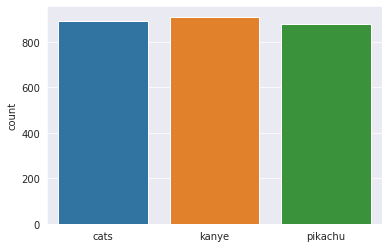

In [12]:
l = []
for i in train:
    if i[1] == 0:
        l.append("cats")
    elif i[1] == 1:
        l.append("kanye")
    else:
        l.append("pikachu")
sns.set_style('darkgrid')
sns.countplot(l)

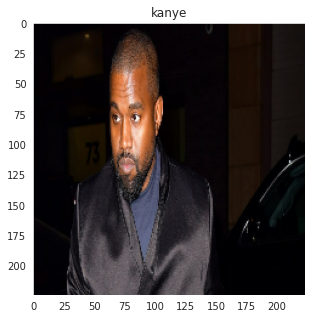

In [13]:
plt.figure(figsize = (5,5))
plt.imshow(train[1050][0])
plt.title(labels[train[1050][1]])
plt.grid(False)

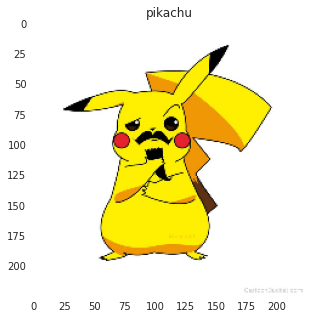

In [14]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])
plt.grid(False)

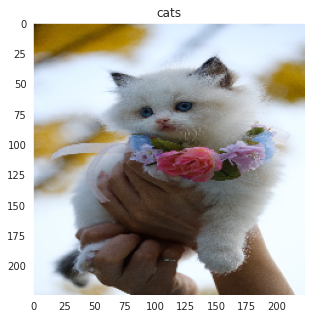

In [15]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.grid(False)

In [16]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

In [17]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [18]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [20]:
base_model = tf.keras.applications.VGG16(input_shape = (img_size, img_size, 3), include_top = False, weights = "imagenet")
base_model.trainable = False

In [21]:
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Flatten(input_shape=(img_size, img_size, 3)),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(3, activation='sigmoid')
                      ])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
history = model.fit(x_train, y_train, epochs = 30, validation_data = (x_val, y_val))

Epoch 1/30
84/84 [==============================] - 25s 242ms/step - loss: 0.9075 - accuracy: 0.5736 - val_loss: 0.6181 - val_accuracy: 0.7978
Epoch 2/30
84/84 [==============================] - 16s 185ms/step - loss: 0.5277 - accuracy: 0.7995 - val_loss: 0.5049 - val_accuracy: 0.8169
Epoch 3/30
84/84 [==============================] - 16s 188ms/step - loss: 0.4119 - accuracy: 0.8521 - val_loss: 0.4166 - val_accuracy: 0.8648
Epoch 4/30
84/84 [==============================] - 16s 190ms/step - loss: 0.3515 - accuracy: 0.8760 - val_loss: 0.3888 - val_accuracy: 0.8689
Epoch 5/30
84/84 [==============================] - 16s 192ms/step - loss: 0.3021 - accuracy: 0.8996 - val_loss: 0.3458 - val_accuracy: 0.8798
Epoch 6/30
84/84 [==============================] - 16s 194ms/step - loss: 0.2651 - accuracy: 0.9253 - val_loss: 0.3196 - val_accuracy: 0.8934
Epoch 7/30
84/84 [==============================] - 16s 195ms/step - loss: 0.2356 - accuracy: 0.9287 - val_loss: 0.3051 - val_accuracy: 0.9030

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

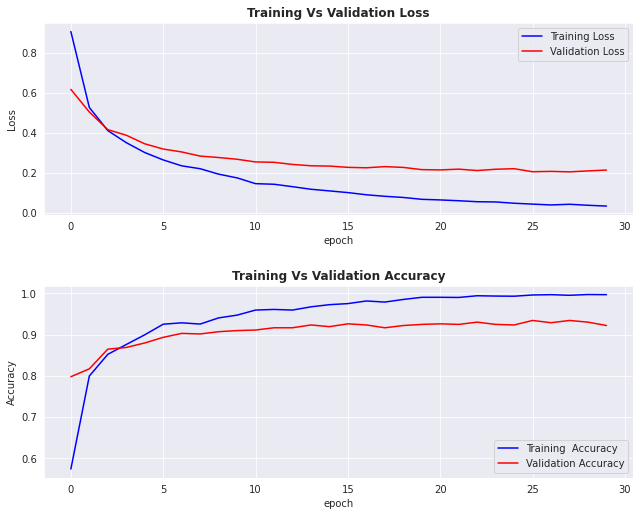

In [26]:
#Plotting the training and validation loss and accuracy
f,ax = plt.subplots(2,1, figsize=(10, 8)) 
f.tight_layout(pad=5.0)
#Loss
ax[0].plot(loss, color='b', label='Training Loss')
ax[0].plot(val_loss, color='r', label='Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title("Training Vs Validation Loss", fontweight="bold")
ax[0].legend()

#Accuracy
ax[1].plot(accuracy, color='b', label='Training  Accuracy')
ax[1].plot(val_accuracy, color='r', label='Validation Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title("Training Vs Validation Accuracy", fontweight="bold")
ax[1].legend()

In [27]:
model.save('/content/drive/MyDrive/Plaksha/Data-X2/Final_Assignment/Image_Classifier.h5')

In [28]:
#Making prediction
y_pred = model.predict(x_val)
y_true = np.argmax(y_val,axis=1)
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(y_true, y_pred, target_names = ['cat', 'kanye', 'pikachu']))

              precision    recall  f1-score   support

         cat       0.96      0.88      0.92       242
       kanye       0.90      0.94      0.92       255
     pikachu       0.92      0.95      0.93       235

    accuracy                           0.92       732
   macro avg       0.92      0.92      0.92       732
weighted avg       0.92      0.92      0.92       732



In [29]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    title = "Confusion Matrix"
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

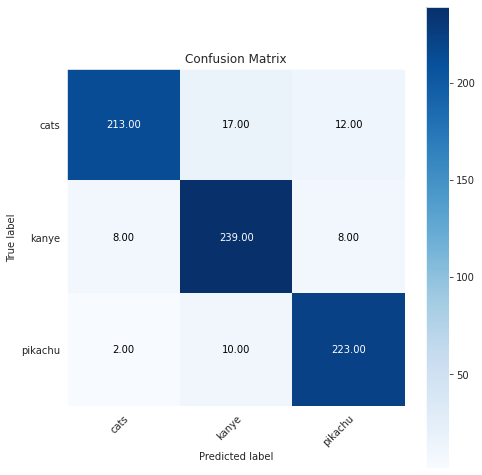

In [30]:
#Defining the class labels
class_names=['cats', 'kanye', 'pikachu']
plot_confusion_matrix(y_true, y_pred, classes = class_names)

In [31]:
def get_test_data(dir):
    data = [] 
    count = 0
    path = dir
    for img in tqdm(os.listdir(path)):
        try:
            img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr])
        except Exception as e:
            count += 1
    return np.array(data)

In [32]:
test = get_test_data(os.path.join(test_path, 'pikachuVkanyeVcats'))

100%|██████████| 96/96 [00:05<00:00, 18.82it/s]


In [33]:
test_images =  [test_path + 'pikachuVkanyeVcats/' + img for img in sorted(os.listdir(test_path + '/pikachuVkanyeVcats'))]

def read_image(file_path):
    im = np.array(Image.open(file_path))
    return im

def plot_pic(img):
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.grid(False)
    plt.show()

In [34]:
def predict_image(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        print(test_images[idx].split('/')[-1])
        print("*"*100)
        prob_pred = mod.predict(test.reshape(-1, img_size, img_size, 3),verbose=0)[idx]
        class_pred = np.argmax(prob_pred)
        
        if class_pred == 0:
            prob_pred = prob_pred[0]
            class_guess='CAT'
        elif class_pred == 1:
            prob_pred = prob_pred[1]
            class_guess='KANYE'
        else:
            prob_pred = prob_pred[-1]
            class_guess='PIKACHU'

        plot_pic(test_images[idx])
        print('I think this is a ' + class_guess + ' with ' +str(round(float(prob_pred)*100,5)) + '% probability')
        print()


In [35]:
loaded_model = load_model("/content/drive/MyDrive/Plaksha/Data-X2/Final_Assignment/Image_Classifier.h5")

cats_Image_990.jpg
****************************************************************************************************


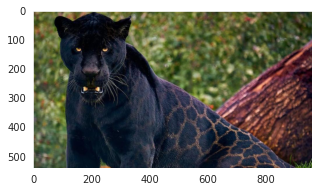

I think this is a CAT with 100.0% probability

cats_Image_338.jpg
****************************************************************************************************


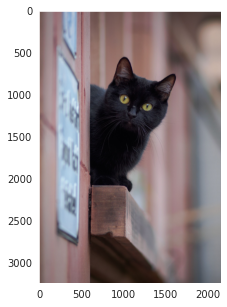

I think this is a CAT with 100.0% probability

cats_Image_988.jpg
****************************************************************************************************


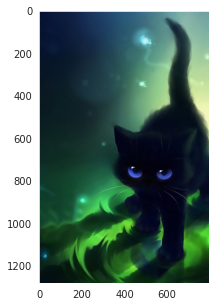

I think this is a CAT with 100.0% probability

pikachu_Image_503.png
****************************************************************************************************


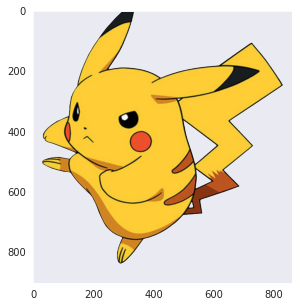

I think this is a PIKACHU with 100.0% probability

pikachu_Image_313.png
****************************************************************************************************


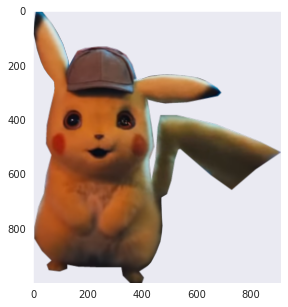

I think this is a PIKACHU with 100.0% probability

kanye_Image_976.jpg
****************************************************************************************************


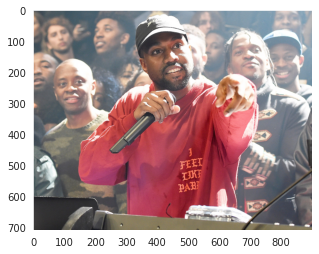

I think this is a KANYE with 100.0% probability

cats_Image_16.jpg
****************************************************************************************************


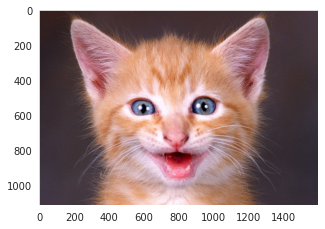

I think this is a CAT with 100.0% probability

pikachu_Image_972.jpg
****************************************************************************************************


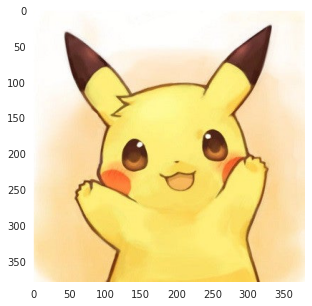

I think this is a PIKACHU with 100.0% probability

cats_Image_971.jpg
****************************************************************************************************


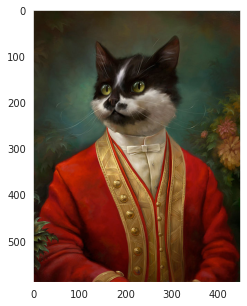

I think this is a CAT with 100.0% probability

pikachu_Image_981.jpg
****************************************************************************************************


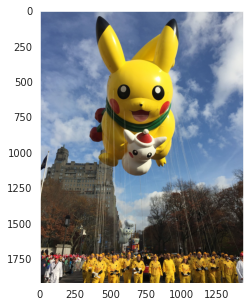

I think this is a PIKACHU with 100.0% probability

pikachu_Image_995.jpg
****************************************************************************************************


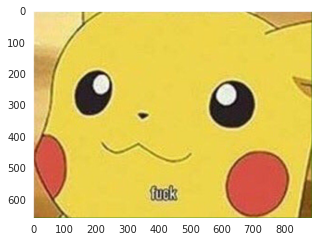

I think this is a PIKACHU with 100.0% probability

kanye_Image_987.jpg
****************************************************************************************************


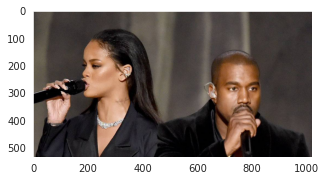

I think this is a KANYE with 100.0% probability

pikachu_Image_99.jpg
****************************************************************************************************


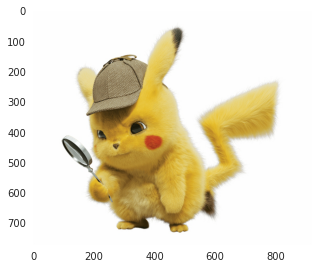

I think this is a PIKACHU with 100.0% probability

kanye_Image_223.jpg
****************************************************************************************************


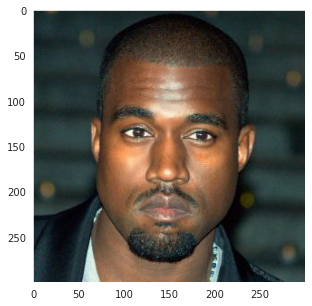

I think this is a KANYE with 100.0% probability

cats_Image_980.jpg
****************************************************************************************************


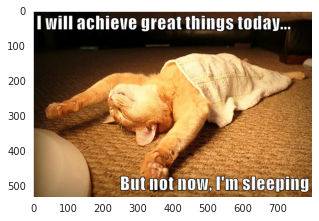

I think this is a CAT with 100.0% probability

kanye_Image_121.png
****************************************************************************************************


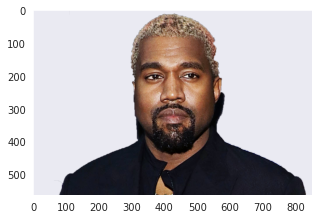

I think this is a KANYE with 100.0% probability

cats_Image_630.jpg
****************************************************************************************************


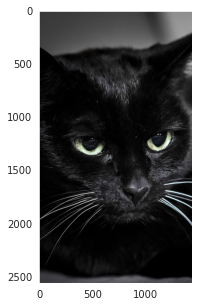

I think this is a CAT with 100.0% probability

kanye_Image_430.jpg
****************************************************************************************************


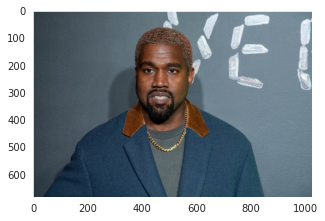

I think this is a KANYE with 100.0% probability

pikachu_Image_201.png
****************************************************************************************************


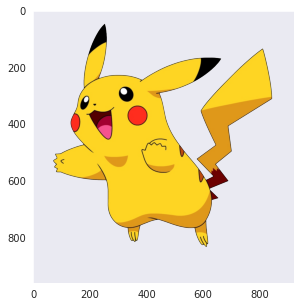

I think this is a PIKACHU with 100.0% probability

pikachu_Image_208.jpg
****************************************************************************************************


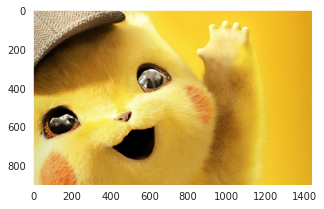

I think this is a CAT with 100.0% probability



In [36]:
idxs = [random.randint(0, len(test)-1) for i in range(20)]
predict_image(loaded_model, r=idxs)